# ЗНАКОМИМСЯ С ДАННЫМИ

Прежде, чем переходить к этапу анализа, необходимо совершить некоторые преобразования над данными, для этого импортируем библиотеки, которые нам пригодятся:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Импортировав библиотеки, откроем в ноутбуке сохранённый в папке data датасет:

In [2]:
ab_data = pd.read_csv('data/ab_data.csv')

И выведем пять первых строк таблицы:

In [3]:
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


Итак, мы получили таблицу со следующими полями:
Название поля 	Описание
user_id 	идентификатор пользователя, зашедшего на сайт
timestamp 	дата события
group 	группа теста (контрольная или тестовая)
converted 	совершил пользователь целевое действие (нажатие кнопки «добавить в корзину» на сопутствующем товаре) или нет. 1 — да, 0 — нет.

Посмотрим тип данных и содержание каждого столбца, для этого применим к датафрейму метод info():



In [4]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


Итак, в наших данных нет пропусков, однако нам нужно перевести столбец с информацией о дате события (timestamp) в формат datetime. Напомним: для этого мы можем воспользоваться функцией pandas to_datetime:

In [5]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')

В итоге мы получили таблицу, в которой отображены входы клиента на сайт (сессия) и его действия. Для того, чтобы получить показатель конверсии в группах на каждый день, нам необходимо предварительно сгруппировать наши данные по дате и группе и вычислить количество пользователей, заходивших на сайт, и суммарное количество совершённых целевых действий. 

Дополнительно для удобства сбросим индекс на сгруппированной таблице c помощью метода reset_index() и переименуем столбец user_id в users_count с помощью метода rename().

In [8]:
daily_data = ab_data.groupby(['timestamp', 'group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


Примечание. Количество пользователей в день в контрольной и тестовой группе определяется как количество значений в столбце user_id в сгруппированных данных, а количество совершённых целевых действий — это просто сумма по столбцу converted (1 в строке означает положительный исход, то есть целевое действие было совершено, а 0 — отрицательный исход; просуммировав все 1 и 0 в группе, получим количество положительных исходов).

Для завершения этапа подготовки данных к анализу нам осталось рассчитать конверсию на каждый день проведения A/B-тестирования. Напомним: ежедневная конверсия рассчитывается как отношение числа посетителей сайта, выполнивших на нём какие-либо целевые действия в день, к ежедневному общему числу посетителей сайта, умноженная на 100 %:

Задание 4.1

Рассчитайте конверсию на каждый день по приведённой формуле. Результат занесите в столбец conversion. Чему была равна конверсия (в процентах) в группе А 5 января 2017 года? Ответ округлите до второго знака после запятой.

In [24]:
daily_data['conversion'] = daily_data['converted'] / daily_data['users_count'] * 100
round(daily_data[(daily_data['timestamp'] == '2017-01-05') & (daily_data['group'] == 'A')]['conversion'], 2)

6    12.32
Name: conversion, dtype: float64

Вычислив ежедневную конверсию, мы получим следующую таблицу:

In [25]:
display(daily_data.head())

,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063
3,2017-01-03,B,6620,754,11.389728
4,2017-01-04,A,6573,797,12.125361


## ВИЗУАЛЬНЫЙ АНАЛИЗ КОНВЕРСИИ В ГРУППАХ

Нам необходимо ответить на вопрос: в какой группе (А или B) показатель конверсии был выше, и на этой основе принять решение о том, какой из вариантов более эффективный. 

Давайте построим диаграмму boxplot для сравнения параметров распределения ежедневной конверсии по группам. 

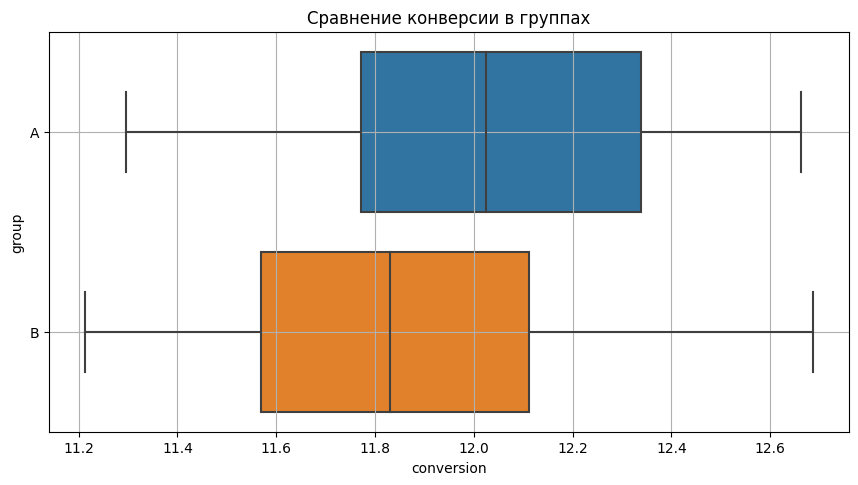

In [26]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для conversion по признаку group
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax) 
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid();

Что можно сказать исходя из этого графика? Во-первых, медианное значение ежедневной конверсии в группе А, выше, чем в группе B. Во-вторых, разброс конверсии в группе B несколько больше, чем в группе A.

Тут неопытный специалист воскликнет: версия рекомендаций А лучше, чем версия B (медиана конверсии варианта А больше, да и разброс поменьше, то есть конверсия более стабильна) — и завершит эксперимент. 

Но выводы делать ещё рано! И сейчас попробуем понять, почему. 

Примечание. Прежде чем делать выводы по визуальному представлению данных, всегда обращайте внимание на численные значения показателей. Они могут различаться в масштабе графика, но на практике разница между ними не будет иметь значения. Также всегда стоит убедиться, что в данных нет выбросов (базовый вариант — сравнить медиану и среднее между собой). Далее мы ещё поговорим о стабилизации показателя во времени.

Давайте вычислим средний и медианный показатель конверсии в контрольной и тестовой группе и умножим результат на 100 (получим результат в процентах):

In [27]:
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
display(conversion_piv)

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


Из полученной таблицы видно, что медиана и среднее в каждой группе практически совпадают. При этом разница между показателями в группах менее 0.3 %! 

?Возникает вопрос: а значима ли вообще такая разница в показателях или она обусловлена случайностью, и варианты A и B одинаково эффективны по метрике конверсии?

Прежде чем отвечать на этот вопрос, нам нужен ответ на другой вопрос: а стабилен ли показатель конверсии в группах во времени или он колеблется как «уж на сковородке»? 

Тут нам помогут кумулятивные метрики.

## КУМУЛЯТИВНЫЕ МЕТРИКИ

В течение всего теста рекомендуется отслеживать поведение целевых метрик. Для этого чаще всего используются кумулятивные метрики.

Кумулятивная метрика — это отображение целевой метрики, когда вы отслеживаете её поведение за каждый день — накопленным итогом по дням. 

### Почему это важно?

Ранее мы говорили, что для принятия решения в A/B-тестировании требуется большой объём данных, что соотносится с законом больших чисел: чем больше данных — тем ближе получаемый результат к математическому ожиданию (истинному среднему). 

Вспомните пример про подбрасывание монетки. Если подбросить монетку 10 раз, то велика вероятность, что один из двух результатов будет значительно превышать второй. Но если подбросить её 1 000 раз, то результаты компенсируют друг друга, и мы увидим, что итог крайне близок к разделению 50/50 (количество выпавших орлов и решек будет практически одинаковым).

Так же и в A/B-тестировании: с самого начала любой из вариантов может показывать лучшие результаты, и статистическая значимость может быть достигнута уже в первые дни теста. Это явление называется проблемой подглядывания.

Важно! Не стоит торопиться: как минимум дождитесь накопления запланированных объёмов выборки и длительности теста. Но и тут не стоит заканчивать тест — проверьте, стабилизировались ли метрики!

То есть в начале теста любой полученный за день результат будет оказывать сильное влияние на результат теста. Но со временем данные будут накапливаться, и доля получаемых за день данных будет всё меньше и меньше воздействовать на уже накопленный результат. 

Кумулятивный график конверсии может выглядеть, например, так: 

Как видите, в начале данные подвержены сильному колебанию, но со временем они выравниваются.

Примечание. Кумулятивная метрика считается стабилизированной, когда на графике прекращаются резкие пики и спады показателя, и линия постепенно выравнивается в горизонтальную прямую.

Важно! Принимать какие-либо решения стоит только после того, как метрика стабилизируется!

Согласно центральной предельной теореме и закону больших чисел, с увеличением объёма данных метрика стабилизируется и будет стремиться к реальному среднему. 

Примечание. В качестве кумулятивной метрики можно считать не только конверсию, но и выручку, средний чек, количество заказов, процент негативных комментариев, точность модели и так далее.

Итак, давайте применим новые знания к нашим данным и вычислим кумулятивную конверсию, а затем построим её график. 

Но для начала ради эксперимента посмотрим, как вообще изменялись показатели ежедневной конверсии в каждой группе во времени. Для этого построим линейные графики для каждой группы: по оси абсцисс отложим дату, а по оси ординат — показатель конверсии:

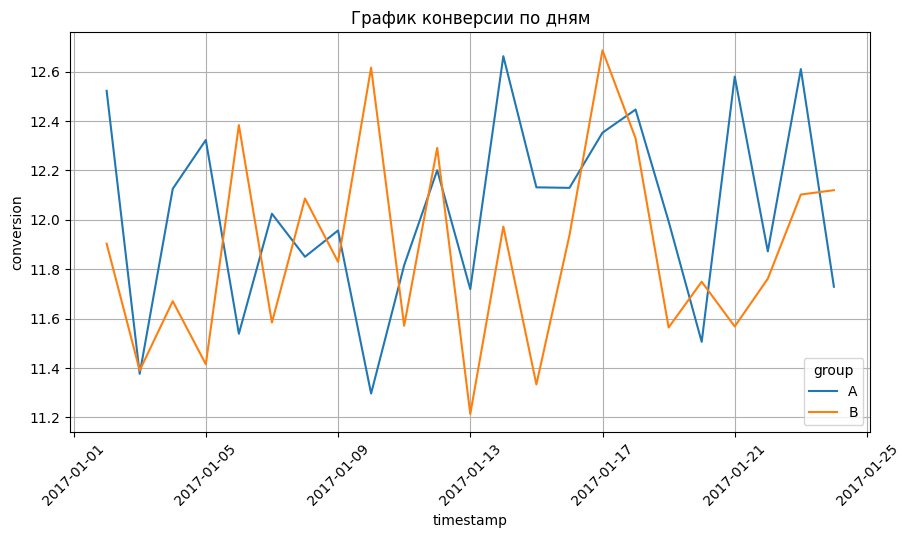

In [28]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='conversion',
    hue='group', 
    ax=ax
)
# задаём подпись к графику
ax.set_title('График конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid();

Что можно сказать по такому графику? Да практически ничего! Конверсия у обеих групп «скачет» день ото дня. Понять, какая из групп лучше, — практически невыполнимая задача. 

Именно поэтому и принято смотреть график кумулятивной конверсии, где за каждый день отображаются данные накопленным итогом.

Для расчёта кумулятивного показателя суммы в Pandas есть специальный метод cumsum(). Давайте посмотрим, как он работает — сначала на данных о ежедневном количестве посетителей для группы А. 

Выберем данные для группы А и создадим в полученной таблице новый столбец cum_users_count, в который запишем результат работы метода cumsum() по столбцу users_count:



In [29]:
# выделяем данные группы А
daily_data_a = daily_data[daily_data['group'] == 'A']
# считаем кумулятивное количество посетителей
daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()
# выводим время, количество посетителей и кумулятивное количество посетителей
display(daily_data_a[['timestamp', 'users_count', 'cum_users_count']].head())

/tmp/ipykernel_65771/906787284.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()


,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031


То есть кумулятивная сумма — это накопительная сумма; каждое её значение — это результат сложения показателя за предыдущие дни с показателем за текущий день. 
Как сделать такой расчёт для двух групп (А и B) сразу? Воспользуемся методом groupby: сгруппируем данные по признаку группы, и в каждой группе будем вычислять кумулятивные суммы признаков количества посетителей (users_count) и количества совершённых целевых действий (converted). 

После этого рассчитаем кумулятивную конверсию — это отношение ежедневной кумулятивной суммы количества посетителей к ежедневной кумулятивной сумме количества совершённых целевых действий:

In [30]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count'] * 100
display(daily_data.head())

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


А теперь построим графики кумулятивной конверсии по дням в каждой группе:

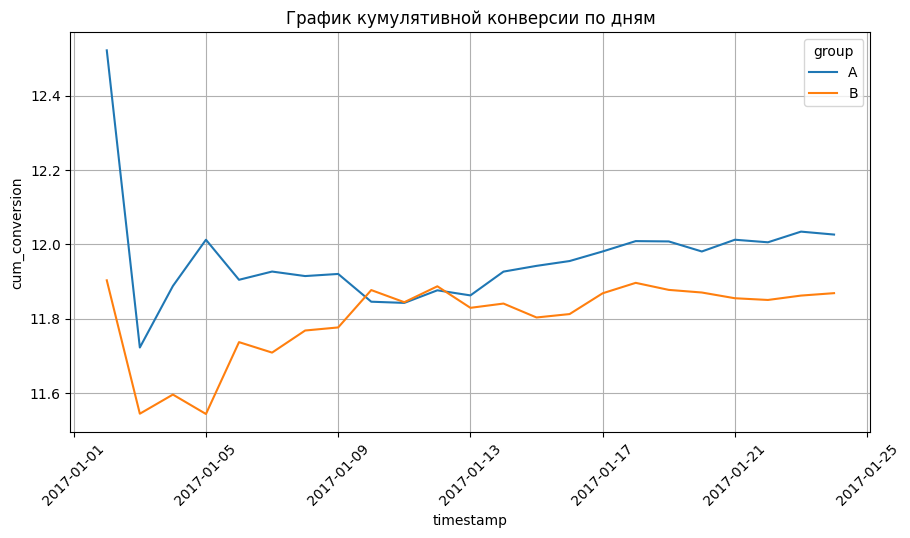

In [31]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Что можно сказать теперь? До 2017-01-09 конверсия была нестабильна, но после 2017-01-11 резкие скачки прекратились (кривая графика переходит в прямую). Судя по графику, конверсия группы B стабильно хуже конверсии группы А на всём промежутке времени. 

Обратите внимание на различие в конверсии в первые дни теста: тут наглядно отображена проблема подглядывания, когда статистическая значимость ошибочно могла быть достигнута уже в самом начале теста.

На основании стабилизированного кумулятивного графика мы можем сделать вывод, что длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателем конверсии в группах.

⭐️ Значит, мы можем переходить к проведению статистических тестов. Но прежде предлагаем решить несколько заданий.

Вводные данные для задач 4.6–4.9

Проводится A/B-тестирование для двух вариантов дизайна сайта. Результаты тестирования собраны в двух файлах (данные для группы А и для группы B).

In [33]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.csv')

sample_a.head()

,date,cid,transactions,revenue,group
0,2020-11-06,1.001648e+09,0,0,A
1,2020-11-06,1.001936e+09,0,0,A
2,2020-11-06,1.003214e+08,0,0,A
3,2020-11-06,1.004393e+09,0,0,A
4,2020-11-06,1.006382e+09,0,0,A


Задание 4.6

Постройте таблицу со следующими ежедневными показателями:

    количество посетителей сайта;
    суммарное число транзакций;
    общая сумма покупок (выручка).

Для этого сгруппируйте данные по признаку date, предварительно преобразовав его к типу datetime.

Чему равны значения ежедневных показателей в группе А на 8 ноября 2020 года?

In [39]:
sample_a['date'] = pd.to_datetime(sample_a['date'])
sample_a_grouped =  sample_a.groupby(by='date').agg({
    'cid':'count',
    'transactions':'sum',
    'revenue':'sum'
}).reset_index().rename(columns={
    'cid':'users_count',
    'transactions':'sum_transactions',
    'revenue':'sum_revenue'
})
sample_a_grouped[sample_a_grouped['date'] == '2020-11-08']

,date,users_count,sum_transactions,sum_revenue
2,2020-11-08,3354,25,846051


In [40]:
sample_b['date'] = pd.to_datetime(sample_b['date'])
sample_b_grouped =  sample_b.groupby(by='date').agg({
    'cid':'count',
    'transactions':'sum',
    'revenue':'sum'
}).reset_index().rename(columns={
    'cid':'users_count',
    'transactions':'sum_transactions',
    'revenue':'sum_revenue'
})
sample_b_grouped.head()

,date,users_count,sum_transactions,sum_revenue
0,2020-11-06,2499,19,996645
1,2020-11-07,2804,19,555499
2,2020-11-08,3291,24,3044842
3,2020-11-09,3062,25,1285836
4,2020-11-10,3072,30,2414726


Задание 4.7

Добавьте в каждую из таблиц кумулятивные метрики:

    кумулятивное количество посетителей сайта;
    кумулятивное суммарное число транзакций;
    кумулятивная общая сумма покупок (кумулятивная выручка).

Рассчитайте кумулятивную конверсию действия покупки (в процентах) и кумулятивный средний чек (кумулятивная выручка/кумулятивное суммарное число транзакций).

Чему равна средняя кумулятивная конверсия в группах за весь период проведения A/B-теста? Ответ округлите до сотых, знаки процентов не вводите.

In [46]:
sample_a_grouped['cum_users_count'] = sample_a_grouped['users_count'].cumsum()
sample_a_grouped['cum_sum_transactions'] = sample_a_grouped['sum_transactions'].cumsum()
sample_a_grouped['cum_sum_revenue'] = sample_a_grouped['sum_revenue'].cumsum()
sample_a_grouped['cum_conversion'] = sample_a_grouped['cum_sum_transactions']/sample_a_grouped['cum_users_count'] * 100
sample_a_grouped['cum_bill'] = sample_a_grouped['cum_sum_revenue'] / sample_a_grouped['cum_sum_transactions']


sample_b_grouped['cum_users_count'] = sample_b_grouped['users_count'].cumsum()
sample_b_grouped['cum_sum_transactions'] = sample_b_grouped['sum_transactions'].cumsum()
sample_b_grouped['cum_sum_revenue'] = sample_b_grouped['sum_revenue'].cumsum()
sample_b_grouped['cum_conversion'] = sample_b_grouped['cum_sum_transactions']/sample_b_grouped['cum_users_count'] * 100
sample_b_grouped['cum_bill'] = sample_b_grouped['cum_sum_revenue'] / sample_b_grouped['cum_sum_transactions']

display(round(sample_a_grouped['cum_conversion'].mean(), 2))
display(round(sample_b_grouped['cum_conversion'].mean(), 2))


0.71

0.76

 Задание 4.8

Постройте графики кумулятивной конверсии в каждой группе. Какие выводы по ним вы можете сделать?

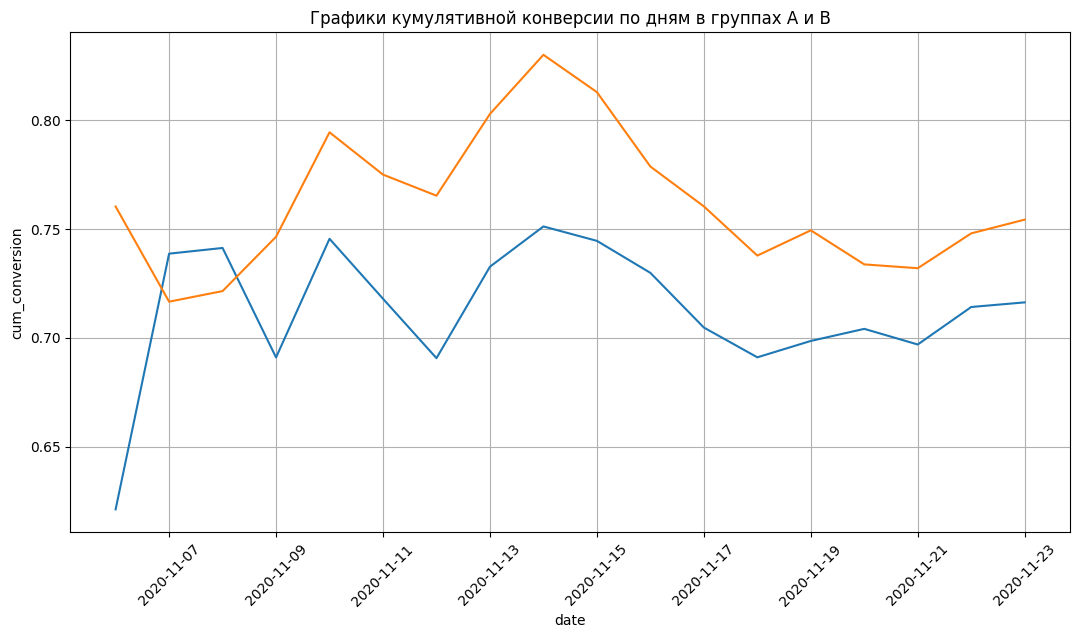

In [56]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(
    data=sample_a_grouped,
    x='date', 
    y='cum_conversion'
    )
sns.lineplot(
    data=sample_b_grouped,
    x='date', 
    y='cum_conversion'
    )
ax.set_title('Графики кумулятивной конверсии по дням в группах A и B')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True);

 Задание 4.9

Постройте графики кумулятивного среднего чека в каждой группе. Какие выводы по ним вы можете сделать?

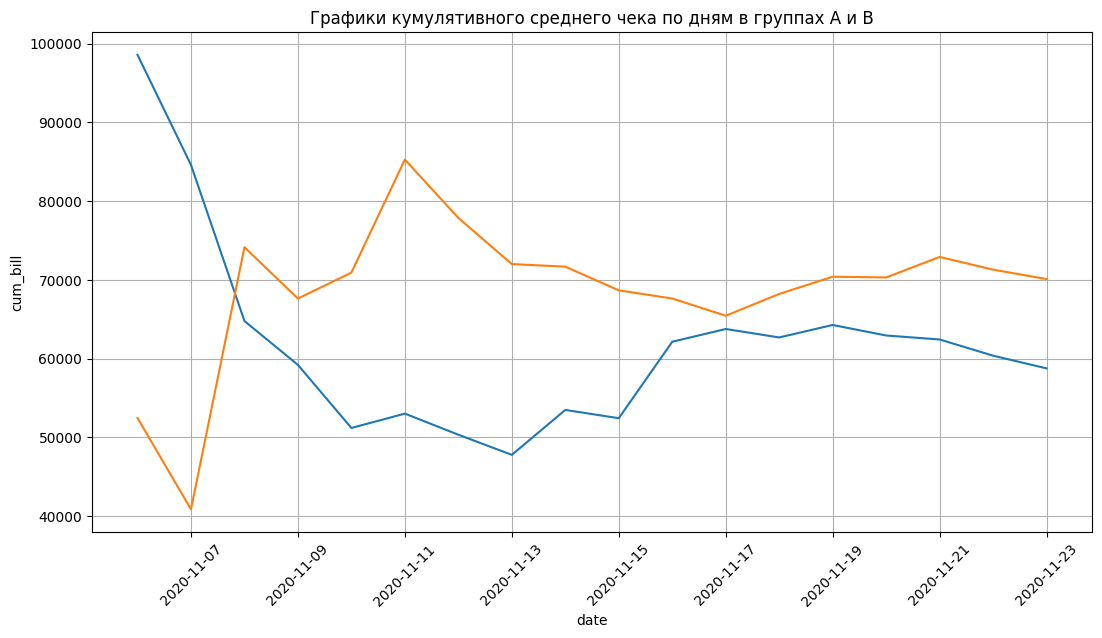

In [55]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(
    data=sample_a_grouped,
    x='date', 
    y='cum_bill'
    )
sns.lineplot(
    data=sample_b_grouped,
    x='date', 
    y='cum_bill'
    )
ax.set_title('Графики кумулятивного среднего чека по дням в группах A и B')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True);


# 5. Анализ результатов A/B-тестирования: статистические тесты

→ В прошлом модуле мы рассматривали различные статистические тесты и их использование в Python. Суть статистических тестов заключается в том, чтобы удостовериться в справедливости некоторой гипотезы или опровергнуть её на основе предоставленных данных (выборки).

А мы как раз этим с вами и занимаемся! 

Наша задача состоит в проверке гипотезы о различиях (равенстве) между истинными конверсиями в группах, исходя из выборочных конверсий. Мы хотим ответить на вопрос: «А существует ли статистическая значимость в эффективности (по конверсии) контрольного и тестового варианта?». 

## СТАТИСТИЧЕСКИЙ ТЕСТ ДЛЯ КОНВЕРСИИ

Оказывается, интересующий нас признак того, осуществлена конверсия пользователя или нет, — это случайная величина, имеющая распределение Бернулли. Такая случайная величина имеет два возможных исхода: 

    успех (1) — пользователь осуществил конверсию (совершил целевое действие); 
    неуспех (0) — пользователь не осуществил конверсию. 

Мы помним, что конверсия — это доля (пропорция) пользователей, которые добавили сопутствующий товар в корзину. То есть истинная конверсия — вероятность «успеха» (традиционно обозначают как ), или вероятность того, что пользователь совершит целевое действие.

Для проверки гипотезы равенства пропорций мы можем воспользоваться уже знакомым нам z-критерием для пропорций. Этот критерий является наиболее популярным для задачи определения статистической значимости изменения конверсии.

Примечание. Здесь и далее, когда мы говорим о равенстве, мы не имеем в виду фактическое равенство показателей (2=2). Мы хотим узнать, есть ли статистическое различие между полученными значениями. Но для простоты изъяснения обычно говорят просто о равенстве или неравенстве.

Например, мы можем иметь конверсию в 4 % для одной группы и в 4.5 % для другой. Фактически показатели не равны. Но это не говорит о том, что конверсия для другой группы лучше — возможно, подобное отклонение в пределах допустимого для рассматриваемых данных, и тогда речь о статистическом различии идти не может.




Нулевая гипотеза нашего теста всегда будет звучать следующим образом:

     то есть истинные пропорции в группах равны.

А вот альтернативных может быть несколько:

    (двусторонняя): 

, то есть истинные пропорции в группах не равны.
(левосторонняя):, то есть истинная пропорция группы А меньше, чем в группе B.
(правосторонняя):

    , то есть истинная пропорция группы А больше, чем в группе B.

✏️ Применим z-тест для пропорций на примере конверсии нашего интернет-магазина. 

Импортируем функцию proportions_ztest() из модуля statsmodels:

In [57]:
from statsmodels.stats.proportion import proportions_ztest

Напомним, что для получения z-статистики и p-value нам необходимо передать в функцию следующие аргументы:

    count — количество «успехов» (в каждой из групп). В нашем случае — количество пользователей, которые совершили целевое действие в каждой группе.
    nobs — количество наблюдений (в каждой из групп), то есть размер выборки.
    alternative — альтернативная гипотеза. Может быть: 'two-sided' — двусторонняя, 'smaller' — левосторонняя, 'larger' — правосторонняя. По умолчанию параметр равен 'two-sided'. 

✏️ Итак, сгруппируем данные по признаку группы и рассчитаем количество «успехов» (сумма по столбцу converted) и общее количество наблюдений (количество непустых значений в столбце converted) для каждой группы.

In [58]:
converted_piv= ab_data.groupby('group')['converted'].agg(
    ['sum', 'count']
)
display(converted_piv)

,sum,count
group,,
A,17467,145241
B,17238,145241


Теперь у нас с вами есть всё для того, чтобы проверить гипотезу о равенстве конверсий. 

Итак, будем проверять следующую новую гипотезу:

    , то есть конверсии в группах А и B равны.

При правосторонней альтернативной гипотезе (ранее из кумулятивных графиков мы видели, что кумулятивная конверсия в группе А выше, чем в группе B, поэтому мы хотим удостовериться в этом с помощью статистического теста, и нам подойдёт правосторонняя гипотеза):

    , то есть конверсия в группе А выше, чем конверсия в группе B.

Зададим уровень значимости и будем сравнивать полученное p-value с ним. По умолчанию функция proportions_ztest() возвращает z-статистику и p-value для двусторонней альтернативной гипотезы (конверсии в группах не равны). 

✏️ Z-статистика нас пока что не интересует, а вот p-value занесём в отдельную переменную для дальнейшего сравнения с уровнем значимости.

In [59]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value:  0.1
# Принимаем нулевую гипотезу. Конверсии в группах А и B равны

p-value:  0.1
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Итак, мы получили

. Оно больше, чем заданный уровень значимости 0.05, а значит мы должны принять нулевую гипотезу о равенстве конверсий. 

Что это значит для нас и для бизнеса? Так как z-тест для пропорций показал, что истинные значения конверсий в группах равны (с уровнем значимости 0.05), то полученная разница в метрике в группах статистически не значима. Переводим на язык бизнеса: разницы между вариантами рекомендаций сопутствующих товаров нет — они одинаково эффективны по метрике конверсии! 

На основе этого вывода мы принимаем решение о том, что делать дальше. Возможные варианты:

    отказаться от внедрения ML-модели для рекомендаций сопутствующих товаров и оставить использование текущей версии рекомендаций;
    попытаться усовершенствовать модель и провести тестирование снова;
    использовать оба варианта системы рекомендаций и посмотреть на результат в более долгосрочной перспективе.

Примечание. Важно отметить, что тест для пропорций можно применять не только к конверсии. Например, так же можно оценивать долю больных людей, долю просроченных кредитов и так далее.

✏️ Заметим, что, если повысить уровень значимости до , то есть «ослабить» требование по точности, можно получить уровень конверсии в группе А, всё-таки превышающий конверсию в группе B. Выполните предыдущий код, чтобы убедиться в этом. Предварительно задайте значение переменной . 

Результат должен быть следующим:

p-value:  0.1
Отвергаем нулевую гипотезу. Конверсии в группах А и B равны
Альтернативная гипотеза. H1: Конверсия в группе А выше, чем конверсия в группе B

Таким образом, при уровне значимости гипотеза о равенстве конверсий всё же отвергается. В таком случае считается, что первая версия рекомендаций лучше, чем вторая версия. 

Какой уровень значимости выбрать?

Стараются придерживаться уровней значимости или . Помним, что больший уровень значимости подразумевает больший риск совершить ошибку I рода (отклонить верную нулевую гипотезу).
Вы сами определяете уровень значимости в зависимости от вашей гипотезы и того, сколько будет стоить вам ошибка I рода.
Как правило, если возникают спорные ситуации, то склоняются в пользу уже существующего варианта А, так как он не требует временных и денежных затрат на внедрение.
В нашем примере варианты А и B оказались равными по признаку конверсии при уровне значимости , однако при уровне значимости вариант А оказывается более эффективным.
Так или иначе, немедленное внедрение варианта B — определённо не лучшая идея. Либо его необходимо доработать и провести тестирование заново, либо стоит отказаться от него вовсе.


## СТАТИСТИЧЕСКИЕ ТЕСТЫ ДЛЯ ДРУГИХ МЕТРИК

На самом деле наша с вами задача об оценке эффективности двух вариантов была очень упрощена. Мы с вами рассматривали только одну метрику — конверсию добавления в корзину. Но на деле обычно смотрят на несколько показателей в комплексе!

Помимо конверсии, нужно рассматривать и другие метрики, например средний чек. Возможно же такое, что конверсия в группах одинаковая, а вот средние чеки существенно различаются! 

В таком случае проводятся статистические тесты для обеих метрик, и решение принимается в пользу варианта, который эффективнее по более приоритетной метрике (например, если мы хотим повысить прибыль, это будет средний чек).

Что делать с другими метриками?
А всё то же самое! Мы выполняем аналогичные действия: проводим визуальный анализ показателей, смотрим на кумулятивные графики, проводим статистический тест (строим доверительный интервал, речь о котором пойдёт далее) и определяем статистическую значимость разницы в показателях.

При этом важно помнить о том, что любой статистический метод имеет свою область применения, которая зависит от задачи и распределения данных. Перед тем как проводить статистический тест, важно узнать распределение метрики, по которой вы будете сравнивать. Вспомните диаграмму-алгоритм по выбору статистического теста из прошлого модуля. 


Например, время, проведённое на сайте, часто распределено нормально, и тогда мы можем использовать T-тест для средних (напомним, данный тест требует, чтобы данные были распределены нормально).

А вот денежные метрики, такие как средний чек, часто (но не всегда) напоминают логнормальное распределение (большинство распределений сосредоточены близ нуля, и частота постепенно падает):

На графике изображён пример сглаженного по гистограмме распределения среднего чека. Видно, что с увеличением ежедневного среднего чека падает его частота.

Для них T-тест уже не подойдёт. Здесь, как правило, используются непараметрические тесты, например критерий Манна-Уитни и другие. Данные тесты применяются в случаях, когда распределение показателя отлично от нормального.

Для проверки распределения на нормальность мы всегда можем воспользоваться тестом Шапиро-Уилка или тестом Д’Агостино .

Давайте рассмотрим следующий пример.

Мы проводим A/B-тест, чтобы оценить, влияет ли тема оформления на привлекательность сайта для пользователя. Гипотеза заключается в том, что тёмная тема более привлекательная для наших посетителей, поэтому их сильнее заинтересует наш сайт, следовательно, они проведут на нём больше времени. Уровень значимости равен 5 %.

Результаты тестирования представлены в следующем XLSX-файле:

In [60]:
time_data = pd.read_excel('data/time_data.xlsx')
display(time_data.head())

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2
3,480.0,637.2
4,561.0,712.4


✏️ Построим гистограмму времени, проведённом пользователями на сайте в каждой из групп:

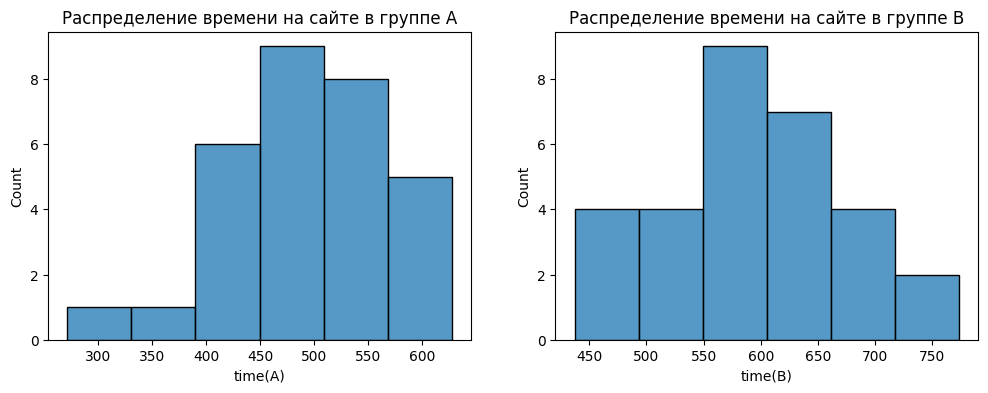

In [61]:
#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='time(A)', data=time_data, ax=axes[0])
sns.histplot(x='time(B)', data=time_data, ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');

Гистограммы напоминают нормальное распределение. Давайте проверим гипотезу о нормальности обоих распределений с помощью критерия Шапиро-Уилка. Для этого используем функцию shapiro() из модуля scipy.stats:

In [62]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(time_data['time(A)'])
shapiro_result_b = shapiro(time_data['time(B)'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value группы А 0.43
# p-value группы B 0.12
# Принимаем нулевую гипотезу. Распределения в обеих группах нормальные

p-value группы А 0.43
p-value группы B 0.12
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


Итак, распределение в обеих группах нормальное, а значит, мы можем воспользоваться T-тестом для того, чтобы сравнить среднее время посещения сайта в группах.

Выдвигаем нулевую гипотезу:

    , то есть среднее время в группах А и B одинаково.

При левосторонней альтернативной гипотезе:

    , то есть среднее время в группе А меньше, чем в группе B.

✏️ Применим T-тест для сравнения средних — функцию ttest_ind() из модуля scipy.stats. Обратите внимание, что левосторонняя альтернативная гипотеза в модуле scipy указывается в параметре alternative как 'less' (правосторонняя — 'greater’):

In [65]:
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Среднее время в группах одинаково'
H1 = 'Среднее время в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value: 0.0
# Отвергаем нулевую гипотезу. Среднее время в группах одинаково
# Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B

p-value: 0.0
Отвергаем нулевую гипотезу. Среднее время в группах одинаково
Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B


Обратите внимание: мы запрашивали значение p-value, округлённое до двух знаков после запятой, но на выводе получили 0.0 — значение только с одним знаком после запятой. Где же второй? Дело в том, что Python не выводит на конце числа больше одного нуля. Значит, 0.0 следует читать как 0.00. Без округления мы бы увидели значащие цифры далеко после запятой. Однако нас интересуют только две после запятой, потому что с такой точностью задан уровень значимости. Итак, в результате проведения T-теста мы получили

, а это значит, что мы отвергаем нулевую гипотезу в пользу альтернативной: среднее время, проводимое на сайте, в группе А меньше, чем в группе B.

Отсюда можно сделать вывод, что что тёмная тема более привлекательна для наших посетителей, чем светлая. 

⭐️ Обратите внимание, что мы опять же принимаем решение, исходя только из одной метрики, так как другими мы и не обладали. Мы проведём комплексный анализ результатов A/B-тестирования по нескольким метрикам в финальном задании модуля. А пока предлагаем вам решить несколько задач!

Задание 5.2

Проверьте гипотезу о равенстве конверсий в группах А и B при альтернативной гипотезе: Конверсия в группе А меньше, чем конверсия в группе B. Используйте функцию proportions_ztest() из модуля statsmodels.stats.proportion. В качестве уровня значимости возьмите .

Каковы результаты тестирования?

In [81]:
s_a = sample_a['transactions'].agg(['sum', 'count'])
s_b = sample_b['transactions'].agg(['sum', 'count'])
s_ab = pd.concat([s_a, s_b], axis=1, keys=['transactions_a', 'transactions_b'])
s_ab = s_ab.transpose()
s_ab

,sum,count
transactions_a,441,61571
transactions_b,463,61383


In [82]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.1 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=s_ab['sum'], #число "успехов"
    nobs=s_ab['count'], #общее число наблюдений
    alternative='smaller',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 

p-value:  0.22
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Задание 5.3

Проверьте гипотезу о нормальности распределений ежедневного среднего чека с помощью критерия Шапиро-Уилка. В качестве уровня значимости возьмите .

Каковы результаты тестирования?

In [85]:

# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.1 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(sample_a_grouped['cum_bill'])
shapiro_result_b = shapiro(sample_b_grouped['cum_bill'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.0
p-value группы B 0.0
Отвергаем нулевую гипотезу. Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


Задание 5.4

Проверьте гипотезу о равенстве ежедневных средних чеков с помощью критерия Манна-Уитни при альтернативной гипотезе: Ежедневный средний чек в группе А меньше, чем в группе B. Используйте функцию mannwhitneyu() из модуля scipy.stats. В качестве уровня значимости возьмите .

Каковы результаты тестирования?

In [101]:
sample_a['bill'] = sample_a['revenue'] / sample_a['transactions']
sample_a['bill'] = sample_a['bill'].fillna(value=0)
bill_a = sample_a.groupby('date', as_index=False)['bill'].agg('mean')

sample_b['bill'] = sample_b['revenue'] / sample_b['transactions']
sample_b['bill'] = sample_b['bill'].fillna(value=0)
bill_b = sample_b.groupby('date', as_index=False)['bill'].agg('mean')

In [102]:
from scipy.stats import mannwhitneyu
# нулевая и альтернативная гипотезы
H0 = 'Ежедневный средний чек в группах А и B одинаков'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B'
alpha = 0.1 # уровень значимости
_, p = mannwhitneyu(bill_a['bill'], bill_b['bill'], alternative='less')
# выводим результат на экран
print('p-value: ', round(p, 2))
# сравниваем полученное p-value с уровнем значимости
if (p < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.07
Отвергаем нулевую гипотезу. Ежедневный средний чек в группах А и B одинаков
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше, чем в группе B


# 6. Анализ результатов A/B-тестирования: доверительные интервалы

→ Ещё один важный статистический метод, который нам необходимо изучить — это доверительные интервалы. Давайте ненадолго отвлечёмся от нашей задачи про конверсию на сайте и рассмотрим небольшой, но очень важный для понимания кусочек статистической теории.

Итак, мы с вами знаем, что на основе выборки (части наблюдений) мы всегда можем измерить следующие показатели:

    выборочное среднее (центральная мера распределения);
    выборочное стандартное отклонение (мера разброса);
    выборочную пропорцию (доля объектов из выборки, выбранных по условию, например доля пользователей, совершивших покупки).

Однако эти оценки не являются нашим основным предметом интереса. На самом деле нас интересуют параметры генеральной совокупности: 

    истинное среднее — математическое ожидание (\(\mu\));
    истинное стандартное отклонение (\(\sigma\));
    истинная пропорция (\(p\)).

Если вы взяли выборку клиентов и выяснили их предпочтения, вам важно не то, что вы узнали предпочтения именно этих клиентов — вам важно, что теперь вы знаете предпочтения всех ваших клиентов (генеральная совокупность).

Важно помнить о разнице между выборочными статистиками и параметрами генеральной совокупности.

Выборочная статистика является случайной величиной, ведь она рассчитана на случайной выборке. Если мы возьмём одну выборку и посчитаем значение среднего, мы получим одно значение; возьмём другую — получим другое значение.

А вот параметр генеральной совокупности — это константа, конкретное число, которое, как правило, нам неизвестно и никогда известным не станет. Однако его можно приблизительно оценить!

Существует два способа оценки параметров генеральной совокупности:

⭐ Точечные оценки.
⭐ Интервальные оценки.

С точечными оценками на самом деле мы уже знакомы и не раз их вычисляли — это просто выборочные статистики. Например, мы собрали данные о росте прохожих людей и посчитали среднее, стандартное отклонение и так далее. Почему они точечные? Потому что они дают ответ точечно, то есть в виде одного числа.

С одной стороны, это удобно: взяли выборку, посчитали выборочное среднее и получили ответ, к примеру «средний рост в этой выборке равен 178 см». 

Однако есть у такого подхода и существенный недостаток: полученное значение практически никогда не равно истинному. 

Интервальные оценки — это ещё один способ оценки параметров генеральной совокупности, при использовании которого ответ даётся не в виде одного числа, а в виде интервала. 

Тогда мы скажем так: «Истинный средний рост лежит в интервале от 170 до 179 см с такой-то долей уверенности». Скорее всего, истинный параметр будет находиться внутри этого интервала.

Поиск интервальной оценки заключается в построении доверительного интервала. 

Доверительный интервал — интервал, который с заданной надёжностью покрывает значение неизвестного параметра. 

Например, если вам говорят, что построен 90 %-ый доверительный интервал для среднего роста и имеет вид: (170, 179), то это означает, что с надёжностью в 90 % истинный средний рост (его математическое ожидание) лежит в пределах от 170 см до 179 см. То есть с вероятностью в 90 % ожидается (в среднем), что любой человек из рассматриваемой генеральной совокупности имеет рост от 170 до 179 см.

Доверительные интервалы бывают двусторонними, левосторонними и правосторонними (как гипотезы). Мы с вами будем рассматривать только построение двусторонних доверительных интервалов, так как они являются наиболее популярными.

Любой двусторонний доверительный интервал обладает следующей структурой:

Параметр = Выборочная оценка ± Предел погрешности

Выборочной оценкой может быть среднее, стандартное отклонение, пропорция, медиана и так далее. А о том, как считается предел погрешности, и от чего он зависит, мы поговорим позже. 

В соответствии с этой формулой можно нарисовать доверительный интервал. Обозначим выборочную оценку как \(\bar{x}\), а предел погрешности как \(E\). 

Тогда истинное значение параметра (с заданной степенью надёжности) лежит где-то внутри интервала:

На оси возможных значений параметра откладывается точка \(\bar{x}\). Влево и вправо от \(\bar{x}\) откладывается погрешность \(E\). Обратите внимание, что выборочная оценка всегда находится в центре двустороннего доверительного интервала. В результате построения интервала мы получаем зону, в которой предположительно лежит истинное значение параметра. 

Пример. Мы замеряем температуру тела человека несколько раз. Сделав замеры, мы рассчитали среднюю температуру \(X_{mean}\), она оказалась 36.6 С0, а также рассчитали погрешность E=0.1 С0. 

Тогда границы доверительного интервала для истинного среднего температуры будут следующими: 

    левая (нижняя) граница — \(X_{mean}-E=36.6 C^{0} - 0.1 C^{0} =36.5 C^{0}\);
    правая (верхняя) граница — \(X_{mean}-E=36.6 C^{0} + 0.1 C^{0} =36.7 C^{0}\). 

То есть истинное среднее температуры лежит в диапазоне от 36.5 C0 до 36.7 C0. Математически это пишется так: \(\in  (36.5, 36.7)\). Символ \(\in\) обозначает принадлежность.

## ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ СРЕДНЕГО ПРИ ИЗВЕСТНОМ ИСТИННОМ СТАНДАРТНОМ ОТКЛОНЕНИИ

Самым частым параметром, который хотелось бы оценить, является истинное среднее (математическое ожидание). И начнём мы сразу с задачи:

Была опрошена случайная выборка из 36 жителей региона об их затратах на продукты питания за последний месяц. Выборочное среднее оказалось равным 16 100 рублей.
Допустим, откуда-то известно, что истинное стандартное отклонение расходов равно 12 000 рублей.
Нам нужно построить доверительный интервал для истинных средних расходов жителя данного региона на продукты питания в месяц. Интервал должен определять истинное значение с надежностью в 95 %.

Страшно и непонятно? Давайте разбираться. 

По условию задачи у нас есть выборка размером \(n=36\) человек. Далее, просуммировав затраты жителей региона и поделив на их количество, было получено выборочное среднее \(X_{mean}=16 100\) рублей. Ещё нам дано значение истинного (НЕ выборочного) стандартного отклонения \(\sigma=12 000\) рублей. То есть в среднем разброс затрат составляет 12 000 рублей. Ещё нам сказали, что рассчитанный нами интервал должен быть надёжным с уровнем надёжности \(\gamma=0.95\).  

Теперь, когда мы ввели все обозначения, пора нам познакомиться с формулой доверительного интервала для истинного среднего при известном стандартном отклонении:

    \(\mu=X_{mean}\pm z_{крит} \times \frac{\sigma}{\sqrt{n}}\)

Другая запись этой формулы:

    \(\mu \in (X_{mean} - z_{крит} \times \frac{\sigma}{\sqrt{n}}; X_{mean} + z_{крит} \times \frac{\sigma}{\sqrt{n}})\)

Оба варианта формулы читаются следующим образом: истинное среднее \(\mu\) лежит в диапазоне от \(X_{mean} - z_{крит} \times \frac{\sigma}{\sqrt{n}}\) до \(X_{mean} + z_{крит} \times \frac{\sigma}{\sqrt{n}}\).

Примечание. Не будем сильно углубляться в статистику, скажем лишь то, что данная формула выводится из центральной предельной теоремы — одной из основных теорем теории вероятностей.

Если сопоставить полученную формулу со структурой доверительного интервала, о которой мы говорили выше, можно заметить, что за выборочную компоненту отвечает выборочное среднее \(\bar{x}=X_{mean}\), а за погрешность отвечает выражение \(E=z_{крит} \times \frac{\sigma}{\sqrt{n}}\). 

Подставляя значения в эту формулу и подобрав правильное значение z-критического, мы можем сказать, что истинное среднее лежит в интервале с определённой надежностью. 

И всё в этой формуле было бы прекрасно, если бы мы знали, что такое \(z_{крит}\) и как его вычислять. Давайте узнаем!



## Откуда берётся z-критическое?

Вообще в формуле доверительного интервала для среднего — это случайная величина, имеющая нормальное распределение с математическим ожиданием (центром) и стандартным отклонением (разбросом) .

Компонент

крит в доверительном интервале определяется уровнем надёжности. А что вообще такое уровень надёжности (его ещё называют уровнем доверия)? 

А вот что: , где — уровень значимости или вероятность ошибки I рода. Тогда уровень надёжности — вероятность НЕ допустить ошибку I рода.

Например, мы хотим, чтобы интервал был надёжен на 95 % (). Это означает, что мы хотим покрыть 95 % процентов исходов (всех возможных выборочных средних). Вероятность допустить ошибку I рода — не захватить истинное значение в построенный доверительный интервал — будет равно

(5 %).

Вывод. Под уровнем надёжности понимается вероятность того, что истинное значение параметра окажется в построенном интервале. А под уровнем значимости — вероятность того, что построенный доверительный интервал «промахнётся» и не захватит истинное значение параметра.

То есть мы хотим взять такое значение, при котором в интервале от -критического до критического лежало бы 95 % всех исходов. В двустороннем интервале эти 95 % мы будем брать как раз посередине, чтобы справа и слева осталось 5 %, по 2.5 % с каждой стороны (помним, что нормальное распределение симметрично).

Теперь ничто не мешает решить нашу задачу! Вычисления будем производить с помощью Python. Задаём необходимые для вычисления переменные:

In [105]:
n = 36 # размер выборки
x_mean = 16100 # выборочное среднее
sigma = 12000 # истинное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

Найти значение z-критического для любого уровня значимости можно при помощи функции norm.ppf() из модуля scipy.stats. По специфическим причинам реализации функция возвращает не совсем z-критическое, а его отрицательный модуль, поэтому мы берём его со знаком минус.

Функция norm.ppf(x) возвращает значение z-крит, левее (ниже) которого лежит доля левого хвоста стандартного нормального распределения. Выражение norm.ppf(α/2) вернёт
, то есть значение крит, ниже которого всех значений стандартного нормального распределения. Это число отрицательное, мы берём его со знаком минус, чтобы получить .

In [103]:
from scipy.stats import norm
z_crit = -norm.ppf(alpha/2) # z критическое

Итак, у нас есть все ингредиенты, чтобы «приготовить» доверительный интервал. Вычислим нижнюю и верхнюю границу по формуле. Округлим результат до целого и выведем на экран:

In [107]:
eps = z_crit * sigma/(n ** 0.5) #погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат
 

Доверительный интервал: (12810, 19390)


Примечание. Заметьте, что это универсальный код. Если перед вами возникнет другая задача расчёта доверительного интервала для истинного среднего, то вам достаточно будет правильно поменять значения переменных. Вы можете оформить его в виде функции и сохранить её, чтобы не строить каждый раз новый доверительный интервал

Полученный результат интерпретируется следующим образом: мы на 95 % уверены, что истинные расходы жителей на продукты питания лежат в интервале от 12 180 рублей до 20 020 рублей. 

⚡ Важно! Доверительный интервал не даёт нам 100 % результата. Всегда есть шанс, что мы промахнулись и не захватили истинного значения. Этот шанс как раз равен уровню значимости .
То есть в нашем примере существует 5 %-ый шанс, что истинное среднее расходов вовсе не лежит в интервале от 12 180 до 20 020. Существует вероятность, что математическое ожидание на самом деле равно 5 000 рублей или 25 000 рублей. Но такая вероятность составляет менее 5 %, и это нас устраивает.

К сожалению, нельзя построить доверительный интервал, охватывающий 100 % возможных значений, так как границы такого доверительного интервала — и . Как мы знаем, это абстрактные математические понятия, неприменимые на практике.

Задание 6.5

Аккумуляторный завод производит батарейки, срок службы которых имеет истинное стандартное отклонение в 2.4 месяца. Средний срок службы батареек в случайной выборке из 64 штук составил 12.35 месяца. Необходимо построить 90 %-ный доверительный интервал для истинного среднего срока службы производимой батарейки и ответить на вопросы заданий ниже.

Чему равно значение z-критического для такого интервала? Введите число с двумя знаками после разделительного знака.

In [115]:
n = 64 # размер выборки
x_mean = 12.35 # выборочное среднее
sigma = 2.4 # истинное стандартное отклонение
gamma = 0.90 # уровень надёжности
alpha = 1 - gamma # уровень значимости



from scipy.stats import norm
z_crit = -norm.ppf(alpha/2) # z критическое
z_crit = round(z_crit, 2)
print(z_crit)


1.64


Теперь постройте 90 %-ный доверительный интервал. Используйте критическое значение, округлённое до двух знаков. Ответ введите в виде нижней и верхней границы интервала, округляя результат до двух знаков после разделительной точки.

In [117]:
eps = z_crit * sigma/(n ** 0.5) #погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound, 2), round(upper_bound, 2)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат
 

Доверительный интервал: (11.86, 12.84)


## ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ СРЕДНЕГО ПРИ НЕИЗВЕСТНОМ СТАНДАРТНОМ ОТКЛОНЕНИИ

Внимательный студент заметил, что в формуле доверительного интервала для истинного среднего мы использовали значение истинного стандартного отклонения .

Для правомерного использования формулы истинное стандартное отклонение выборки должно быть известно. Но, как правило, нам неизвестно это значение (если только оно не свалилось на нас озарением), ведь для этого нам нужно знать все значения генеральной совокупности. А если они у нас есть, то нам и доверительные интервалы не нужны — зная всю генеральную совокупность, всегда можно найти истинные параметры.

В реальной жизни нам приходится заменять значение значением выборочного стандартного отклонения, которое мы можем посчитать на основании выборки.

Когда мы заменяем константу на случайную величину, точность всей конструкции явно становится меньше. Вероятно, итоговая величина будет похожа на нормальное распределение, но будет обладать бОльшим разбросом.

Такая случайная величина хорошо описывается распределением Стьюдента, или Т-распределением. 

Распределение Стьюдента — это целое семейство родственников стандартного нормального распределения.

Действительно, центр (среднее) по-прежнему будет в 0, а вот разброс значений (то есть стандартное отклонение) будет уже больше. Этот разброс будет различным в зависимости от степеней свободы ().

На рисунке фиолетовым цветом изображено нормальное распределение с параметрами 0 и 1, а зелёным цветом — распределение Стьюдента. Отчётливо видно, что распределение Стьюдента несколько «шире» — обладает бОльшим разбросом.

Степени свободы  обозначаются d.f. (от англ. degrees of freedom). Они и говорят нам о том, насколько велик разброс в значениях распределения Стьюдента. Этот параметр вычисляется как , где — размер выборки.

Чем больше , тем меньше разброс распределения и тем ближе оно к нормальному, что можно продемонстрировать следующим рисунком:

Тогда в формуле для доверительного интервала случайная нормальная величина заменится на случайную величину , а истинное стандартное отклонение заменится на выборочное —

:

 
крит

Или другая запись этой формулы:

 
криткрит

Значения
крит вычисляются аналогично крит: задаётся уровень надёжности (или уровень значимости ), и на его основе по таблицам или калькуляторам для распределения Стьюдента вычисляется число. Отличие состоит в том, что для вычисления

крит нужно задать ещё и число степеней свободы :

крит

✏️ А теперь давайте решим задачу!

Управляющий супермаркета хочет оценить, сколько денег покупатели тратят за один поход в супермаркет в среднем. На основании ранее собранных данных известно, что расходы одного покупателя распределены приблизительно нормально. Управляющий взял случайную выборку из 15 покупателей и выяснил, что их средние расходы равны 2 000 рублей, а выборочное стандартное отклонение равно 400 рублей.

Для оценки управляющий хочет построить доверительный интервал с надёжностью в 95 %.

Давайте поможем управляющему, решив несколько задачек с помощью Python.

Итак, зададим необходимые для решения задачи переменные:

In [118]:
n = 15 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 2000 # выборочное среднее
x_std = 400 # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

Найти значение t-критического для любого уровня значимости можно, используя функцию t.ppf() из модуля scipy.stats. Для этого в функцию передаётся интересующий уровень значимости (

) и число степеней свободы (). Аналогично z-критическому функция возвращает отрицательный модуль t-критического, поэтому мы берём его со знаком минус:



In [119]:
from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) # t-критическое

Примечание. Интересен тот факт, что значение t-критического при том же уровне надёжности чуть выше, чем значение z-критического, например , а вот  . Благодаря этому доверительный интервал при неизвестном стандартном отклонении гарантировано будет шире, чем при известном, если

. 

Теперь составим доверительный интервал для истинного среднего. Вычислим левую и нижнюю границу по формуле. Округлим результат и выведем на экран:

In [120]:
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал: (1778, 2222)


Итак, мы на 95 % уверены, что истинные траты покупателей в нашем магазине лежат в интервале от 1 778 до 2 222 рублей. Примечание. Важно отметить, что при достаточной выборке (примерно более 30 наблюдений) распределение Стьюдента очень похоже на стандартное нормальное распределение. В этом случае можно использовать первую формулу (z-критическое) даже при неизвестном стандартном отклонении. Однако используя вторую формулу при оценке среднего, вы не ошибётесь.

Ещё один важный факт состоит в том, что обе формулы работают только при соблюдении двух условий:

    Выборка должна быть случайной.
    Выборка должна быть достаточно велика. Но есть исключение: если выборка маленькая, но сама величина распределена нормально, то выборочное среднее тоже будет распределено нормально. В таком случае мы можем пользоваться формулой доверительного интервала.

 

Задание 6.6

Чиновника интересует сумма подоходного налога, выплачиваемого домохозяйствами за год. На случайной выборке из 25 домохозяйств был посчитан средний размер выплаченного налога, и он составил $ 3 540. Также известно выборочное отклонение величины подоходного налога, равное $ 1 150.

Необходимо найти 90 %-ый доверительный интервал для истинного среднего значения налоговых выплат за год. Используйте формулу с t-критическим.

Укажите границы построенного доверительного интервала для истинного среднего. Ответ округлите до целого.

In [121]:
n = 25 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 3540 # выборочное среднее
x_std = 1150 # выборочное стандартное отклонение
gamma = 0.90 # уровень надёжности
alpha = 1 - gamma # уровень значимости

from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) # t-критическое

eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал: (3146, 3934)


## ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ ПРОПОРЦИИ

Настало время вернуться к нашей задаче об анализе конверсии в двух группах A/B-тестирования.

Давайте ещё раз вспомним, что такое конверсия. 

Конверсия — это доля пользователей, совершивших целевое действие, по отношению к общей массе пользователей. 

Ранее мы уже выяснили, что признак того, осуществлена конверсия пользователем или нет — это случайная величина, имеющая распределение Бернулли. Такая случайная величина имеет два возможных исхода: 

    успех (1) — конверсия осуществлена (пользователь совершил целевое действие);
    неуспех (0) — пользователь не совершил целевое действие. 

То есть конверсия — это вероятность того, что пользователь совершит целевое действие (вероятность успеха традиционно обозначается как ):

    — количество успехов (количество пользователей, осуществивших конверсию);
    — общее количество исходов (количество пользователей);
    — конверсия.

Примечание. При расчётах конверсии обычно долю ещё умножают на 100 %.

В контексте задачи A/B-тестирования нам бы хотелось знать истинную конверсию (а не ту, которая подсчитана по выборке) в контрольной и тестовой группе, а также оценить истинную разницу между конверсиями. 

Если подумать, то на самом деле мы решаем задачу оценки истинной пропорции генеральной совокупности по выборке. А значит,  нужно научиться строить доверительный интервал для пропорции.

Забегая вперёд в раздел по теории вероятностей, отметим, что истинное среднее (математическое ожидание) такой случайной величины , а истинное стандартное отклонение

. 

Истинную вероятность успеха , мы, конечно же, не знаем, так как нам неизвестна вся генеральная совокупность (всех возможных пользователей). Вместо неё мы используем выборочную пропорцию (обозначим её как ) — долю совершивших конверсию пользователей, то есть выборочную конверсию. 

Заметим, что истинная пропорция полностью совпадает с истинным средним . Если немного поколдовать с формулой доверительного интервала для истинного среднего, то можно вывести формулу доверительного интервала для истинной пропорции (истинной конверсии):

крит

Другая запись этой формулы:

криткрит

Данная формула позволяет построить доверительный интервал для истинной конверсии в контрольной (А) и тестовой (B) группах.

Если сравнить со структурой доверительного интервала, введённой ранее, то можно заметить, что за выборочную оценку отвечает выборочная пропорция
, а за погрешность интервала отвечает выражение крит

.

Примечание. Если размер выборки < 30, то вместо
крит используется

крит. Но в задачах A/B-тестирования, как правило, такой размер выборки не используется. Чаще всего мы имеем дело с сотнями или тысячами наблюдений.

✏️ Пора приступать к реализации на Python. Будем работать с данными о посетителях веб-сайта из прошлого юнита:

In [122]:
ab_data = pd.read_csv('data/ab_data.csv')
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


Для удобства создадим отдельные таблицы для каждой из групп пользователей:

In [123]:
#фильтруем данные группы А
a_data = ab_data[ab_data['group'] == 'A']
#фильтруем данные группы B
b_data = ab_data[ab_data['group'] == 'B']

Давайте на этот раз оформим расчёт в виде функции: объявим функцию proportions_conf_interval(). У данной функции будет три аргумента: n — размер выборки, x_p — выборочная пропорция и gamma — уровень надёжности (по умолчанию он равен 0.95). Функция будет возвращать кортеж из вычисленных границ доверительного интервала, умноженных на 100 % и округлённых до второго знака после запятой.

In [124]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

Теперь применим нашу функцию к данным группы А и группы B:

In [125]:
conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['converted'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['converted'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.86, 12.19)
Доверительный интервал для конверсии группы B: (11.7, 12.03)


Итак, можно сделать вывод, что с надёжностью в 95 % конверсия группы А лежит в интервале от 11.86 % до 12.19 %, а конверсия группы B лежит в интервале от 11.7 % до 12.03 %.

Если схематично изобразить построенные доверительные интервалы для конверсии в группах А и B, можно отчётливо заметить пересечение интервалов (обозначено синим цветом):



Что значит такое пересечение интервалов для нас? Это значит, что существует вероятность, что истинное значение конверсии в обеих группах может совпасть (попасть в синюю зону). То есть мы не можем однозначно сказать, есть ли разница в конверсиях. Можно даже рассчитать эту вероятность, но лучше пойти другим путём.

Лучше построить доверительный интервал разницы пропорций (конверсий).

Не будем уходить в статистические дебри, просто приведём формулу для расчёта доверительного интервала разницы конверсий в группах. Запоминать её, как и считать руками, не нужно, мы реализуем расчёты с помощью Python. Однако важно понимать её составляющие:

индексы и обозначают принадлежность параметра группе А и B соответственно;
— истинная разница конверсий групп B и A;

    — выборочная разница конверсий групп B и A.

Таким образом, в центре доверительного интервала находится — это выборочная оценка, — а границы интервала задаются погрешностью
крит

.

Допустим, мы построим такой доверительный интервал. Как тогда на его основе сделать выводы и принять решение? Возможны три случая:
- Обе границы доверительного интервала являются положительными (больше 0)

Истинная разница в конверсии положительная. 
В таком случае говорят, что вариант B более эффективен по метрике конверсии, чем вариант А с заданной надёжностью.

- Обе границы доверительного интервала являются отрицательными (меньше 0)

Истинная разница в конверсии
отрицательна. Тогда вариант B хуже по метрике конверсии, чем вариант А с заданной надёжностью.

- Интервал охватывает точку 0

Левая граница доверительного интервала отрицательная, а правая — положительная. То есть истинная разница в конверсии
может быть как положительной, так и отрицательной. Тогда это будет значить, что варианты А и B равнозначны по метрике конверсии. 

Создадим функцию diff_proportions_conf_interval() со следующими аргументами: n — список из размеров выборки для групп А и B соответственно, xp — список из выборочных пропорций для групп А и B соответственно и gamma — уровень надёжности (по умолчанию он равен 0.95). Функция будет возвращать кортеж из вычисленных границ доверительного интервала разницы конверсий, умноженных на 100 % и округлённых до второго знака после запятой.

In [126]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

Вызовем функцию и построим интересующий нас доверительный интервал:

In [127]:
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['converted'].mean(), b_data['converted'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))
 

Доверительный интервал для разности конверсий: (-0.39, 0.08)


Итак, что можно сказать теперь? Построенный доверительный интервал с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.39 % до 0.08 %. 

То есть разница в конверсии с 95 %-ой надёжностью может быть как положительной, так и отрицательной. Мы имеем дело с третьим случаем — интервал охватывает точку 0.

Отсюда можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.

В заключение хотелось бы отметить, что доверительный интервал для пропорции применяется не только для оценки конверсии и разницы конверсий в группах!

Под истинной пропорцией может пониматься доля успешно угаданных моделью объектов (accuracy), доля выздоровевших пациентов или доля ушедших клиентов (отток). То есть такой доверительный интервал может быть применён в любой задаче A/B-тестирования, где признак, по которому считается метрика, бинарный (имеет два возможных исхода — «успех» и «неуспех»). А это очень большой спектр задач!

Таким образом, доверительные интервалы — это ещё один вспомогательный инструмент проведения A/B-тестирования, который позволяет с определённой заранее надёжностью статистически сравнить варианты продукта А и B по заданной метрике. 

⭐️ Обычно доверительные интервалы используются в комплексе со статистическими тестами. Статистический тест показывает, значимы ли наши результаты, а доверительный интервал показывает пределы изменения метрик и их разницы в группах. 

Задание 6.9

Чтобы оценить удовлетворённость клиентов сети отелей, менеджер взял случайную выборку из 189 комментариев, оставленных посетителями на онлайн-платформе по бронированию, и провёл анализ их содержания. Выяснилось, что 132 комментария были положительными, остальные — негативными.

Давайте поможем менеджеру ответить на несколько вопросов!

Чему равна выборочная пропорция положительных комментариев? Укажите с точностью до трёх знаков после разделительной точки.

In [130]:
n = 189
xp = 132/n
print(round(xp, 3))

0.698


Найдите 90 % доверительный интервал для истинной пропорции положительных комментариев. Ответ приведите в процентах и округлите до двух знаков после запятой. При расчёте используйте z-критическое.

In [134]:
diff_inverval = proportions_conf_interval(n, xp, gamma=0.9)
print(diff_inverval)

(64.35, 75.33)


 Задание 6.10

Проводится A/B-тестирование вариантов отображения страницы корзины на сайте интернет-магазина. Есть два варианта отображения страницы: с товарными рекомендациями «Хиты продаж» и персональными, подобранными под интерес конкретно этого пользователя. Метрикой является конверсия действия «добавить в корзину товар из рекомендаций». Были собраны следующие данные:

Группа
	

Число добавленных в корзину товаров
	

Размер выборки

А (Персональные скидки)
	

45
	

1000

B (Хиты продаж)
	

50
	

1000

Постройте 95 %-ый доверительный интервал разности полученных конверсий. Ответ приведите в процентах и округлите границы интервала до второго знака после запятой. При расчёте используйте z-критическое.



In [141]:
sales = pd.DataFrame({'added': [45, 50], 'size': [1000, 1000]}, index=['A', 'B'])
sales['conversion'] = sales['added'] / sales['size']
sales

,added,size,conversion
A,45,1000,0.045
B,50,1000,0.050


In [143]:
n = [sales['size']['A'], sales['size']['B']]
# выборочная пропорция групп A и B
xp = [sales['conversion']['A'], sales['conversion']['B']]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))
 

Доверительный интервал для разности конверсий: (-1.36, 2.36)
